## Finding the Key Parameters in Detecting Heart Disease

### Daisy Intelligence Hackathon

**By Efe Tascioglu (Engsci 2T5) and Micol Altomare (Engsci 2T5)**

*Please Note:* On export, there seems to have been an issue. The code still runs in this version as expected, but there were no errors earlier.

#### Import Libraries and Declare File Names

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

filename1 = "cleveland.data"
filename2 = "switzerland.data"
filename3 = "hungarian.data"
filename4 = "long-beach-va.data"
filename5 = "combined-processed.data"

# from pandas import Series, DataFrame
import seaborn as sb
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

#### Parse The Data
We use all of the data provided by the 4 datasets. We combine all of the data onto one file, and make sure that each row stores 1 patient (instead of 1 patient split over 10 rows). We also set the names of each of the collumns as the header of the file.

In [2]:
outstring = ""
for filename in (filename1, filename2, filename3, filename4):
    f = open(filename, encoding="latin-1")
    data = f.read().split()
    i = 0
    for element in data:
        if i != 75:
            outstring += element + ","
            i += 1
            
        else:
            outstring += element + "\n"
            i = 0
    f.close()
# print(outstring)

f = open(filename5, "w")
f.write(outstring)
f.close()


#### Ideas:
* Binary Regression
* Multiple Linear Regression (with Sigmoid curve to squish results onto a 0-1 scale)
* Classification
#### Goals:
* Find the maximum accuracy that our algorithm can achieve
* FInd whether the 62 parameters commonly ignored by research labs affect the input, by remove each one and retesting the whole thing

#### Load the data and remove useless collumns

In [3]:
# each attribute (keeping in mind that 58 is the target (Dep) variable)
col_names = ["id", "ccf", "age", "sex", "painloc", "painexer", "relrest", "pncaden", "cp", "trestbps",\
            "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist", "restecg", "ekgmo",\
            "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic", "proto", "thaldur", "thaltime",\
            "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak",\
            "slope", "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref", "exerwm",\
            "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num", "lmt", "ladprox",\
            "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox", "rcadist", "lvx1", "lvx2",\
            "lvx3", "lvx4", "lvf", "cathef", "junk", "name"] 

# loading dataset
df = pd.read_csv("combined-processed.data", names=col_names)
df = df.replace(to_replace=-9, value=0)
#df = pd.read_csv("combined-processed.data")
#df.head(3)

In [4]:
# These values are absolutely not necessary because they are not tied with the individuals physicsal health
df = df.drop(columns=["id", "ccf", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", 'name'])
#df.head(3)

In [5]:
x_vals = df.drop(columns="num")
y_vals = df[["num"]] # This is a pandas Dataframe, if you remove one set of [] you get a pandas series
#y_vals.head(3)
#x_vals.head(3)

### Visualizations
###### Checking the degree to which two independent variables are independent:

<AxesSubplot:xlabel='thalrest', ylabel='ekgyr'>

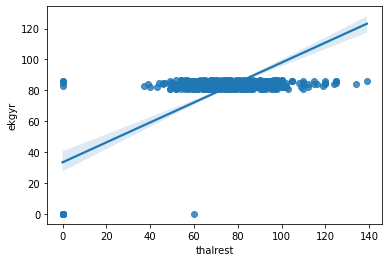

In [6]:
sb.regplot(x=col_names[32], y=col_names[21], data=df, scatter=True)

In [7]:
df # Visualization of the Distribution of inputs using deepnote.com built in dataframe analysis tool.

,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,...,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist
0,63,1,0,0,0,0,1,145,1,233,...,1,1,1,0,1,0,1,0,1,1
1,67,1,0,0,0,0,4,160,1,286,...,1,2,2,0,2,0,1,0,1,1
2,67,1,0,0,0,0,4,120,1,229,...,1,1,1,0,1,0,1,0,2,2
3,37,1,0,0,0,0,3,130,0,250,...,1,1,1,0,1,0,1,0,1,1
4,41,0,0,0,0,0,2,130,1,204,...,1,1,1,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,54,0,1,1,1,0,4,127,0,333,...,1,1,1,1,2,1,1,1,1,1
895,62,1,0,0,0,0,1,0,0,139,...,1,1,1,1,1,1,1,1,1,1
896,55,1,1,1,1,0,4,122,1,223,...,1,2,1,1,1,1,1,1,2,1
897,58,1,1,1,1,0,4,0,0,385,...,1,1,1,1,1,1,1,1,1,1


In [8]:
## Used a Deepnote Visualization tool (not available on export)

### Logistic Regression

One attempted method: use Wald's Test to determine whether each parameter is impacting the solution or not.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=0.25, random_state=0) # Have a 50-50 split for train/test. Do not shuffle every time.
logreg = LogisticRegression(max_iter=10000)
logreg.fit(x_train, y_train)

C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=10000)

In [10]:
y_pred = logreg.predict(x_test)
print(y_pred)

[0 0 0 3 0 0 1 3 0 3 4 3 3 1 2 1 1 4 0 1 0 1 0 3 0 0 1 2 0 3 0 0 1 2 3 2 1
 2 3 0 1 3 3 2 0 0 0 2 3 1 0 0 1 1 0 0 0 3 2 0 0 0 1 3 0 0 0 1 3 0 3 0 1 3
 1 0 0 0 0 1 1 1 0 0 1 0 3 1 0 1 0 3 0 0 2 0 0 0 2 3 1 1 0 0 1 4 0 3 3 1 0
 3 0 3 1 0 0 1 0 0 2 0 0 3 0 0 0 0 0 0 0 3 0 1 0 2 0 2 2 0 3 1 4 0 2 3 1 4
 0 1 3 0 1 4 1 0 2 2 0 2 2 1 1 2 0 3 2 0 0 0 1 2 1 0 0 3 0 2 0 3 2 2 0 3 0
 1 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 4 1 0 0 1 4 0 0 2 1 0
 0 1 0]


In [11]:
baseline_score = logreg.score(x_test, y_test)
print(baseline_score)
print(np.sum(y_pred.round().astype(int).reshape(len(y_pred),1) == y_test)/len(y_test))
# The score function just rounds the prediction to the closest int, and returns the percentage of correct guesses.
# Since there is 5 different values that y can be, this means the algorithm is relatively inconsistent at guessing the correct value (60%).

0.6666666666666666
num    0.666667
dtype: float64


In [12]:
print(np.sum((y_pred>0.5).astype(int).reshape(len(y_pred),1) == (y_test>0.5).astype(int))/len(y_test))
# When we only care about whether heart-disease is present or not (without retraining) we get an accuracy of 80%

num    0.915556
dtype: float64


#### But what if we retrain, while only caring about if heart disease is present?
##### Binary Logistic Regression

In [13]:
y_train = y_train.replace(to_replace=[2,3,4], value=1)
y_test = y_test.replace(to_replace=[2,3,4], value=1)


logreg = LogisticRegression(max_iter=10000)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print(y_pred)



C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1
 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1
 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0
 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1
 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0
 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0
 0 1 0]


In [14]:
print(logreg.score(x_test, y_test))
# 91.5% Accuracy

0.9155555555555556


## Determining the most important parameters

#### Using the SelectKBest Function
This parameter analysis method was attempted but was ultimately not used in the final project

In [15]:
#from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import Variance Threshold
#from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
# chi2 => score function for classification problems

# print(x_vals.shape)
# print(y_vals.shape)
#x_new = SelectKBest(chi2, k=5).fit_transform(x_train, y_train) # verify skb arguments
# first element of inner lists is the att (initial lists are most influential)
#print(x_new)

'''
z = SelectKBest.fit_transform(x_train, y_train) ####
print(z)
# select = SelectKBest(f_classif, k=1)
# print(select)
'''

'\nz = SelectKBest.fit_transform(x_train, y_train) ####\nprint(z)\n# select = SelectKBest(f_classif, k=1)\n# print(select)\n'

#### Using the Accuracy Function

I tried removing 1 parameter, retraining, and testing the score value, to see how much that parameter helped determine heart-disease. However, half the time, this seems to *increase* the score instead of decreasing it. This may be a case of overfitting, so I am going to re-try this but by keeping only 1 parameter instead.

In [16]:
# Repeat the experiment once for each variable, with all variables but 1

x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=0.25, random_state=0) # Have a 75-25 split for train/test. Do not shuffle every time.
new_scores = pd.DataFrame(columns=["parameter", "score"])
#print(new_Scores)
for collumn in x_train:

    curr_x_train, curr_x_test = x_train.drop(columns=collumn), x_test.drop(columns=collumn)

    logreg = LogisticRegression(max_iter=10000)
    logreg.fit(curr_x_train, y_train)

    #y_pred = logreg.predict(curr_x_test)
    #print(y_pred)
    new_scores = new_scores.append(pd.DataFrame([[collumn, logreg.score(curr_x_test, y_test)]], columns=["parameter", "score"]))
    #print("Without the", collumn, "parameter, the Accuracy score is:", new_Scores)    
print(new_scores)    


C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  

C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or 

C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or 

C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or 

C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or 

C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or 

   parameter     score
0        age  0.675556
0        sex  0.680000
0    painloc  0.702222
0   painexer  0.711111
0    relrest  0.697778
..       ...       ...
0      ramus  0.684444
0        om1  0.671111
0        om2  0.666667
0    rcaprox  0.644444
0    rcadist  0.666667

[65 rows x 2 columns]


C:\Users\Efe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
new_scores = new_scores.sort_values(by=['score'])
#for key, value in new_scores.items():
    #if value <= 0.58: # If the value gives a 2% decrease in score
    #    important_values.append(key)

print("These parameters were all crucial to determining heart disease in patients (from most to least important):")
print(new_scores.head(5))
print("These parameters have no significance, or make things worse: ")
print(new_scores.tail(3))

These parameters were all crucial to determining heart disease in patients (from most to least important):
  parameter     score
0       lmt  0.608889
0   laddist  0.622222
0   rcaprox  0.644444
0    cxmain  0.644444
0   ladprox  0.648889
These parameters have no significance, or make things worse: 
  parameter     score
0     slope  0.702222
0   painloc  0.702222
0  painexer  0.711111


#### Key Features found:
If you had to get rid of 1 parameter, which would be the most detremental?

**[lmt]** Left Main Trunk of the Blood Vessel: 

**[laddist]**

**[rcaprox]**

**[cxmain]** Circumflex: 

**[ladprox]**

#### Worst Features found:
Which parameters made things worse?

**[painexer]**

**[painloc]**

**[slope]**

#### Using the Accuracy Function # 2
Repeat last experiment excpt instead of keeping all but 1 parameters, keep only the 1

In [18]:
# Repeat the experiment once for each variable, with all variables but 1

x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=0.25, random_state=0) # Have a 50-50 split for train/test. Do not shuffle every time.
new_scores2 = pd.DataFrame(columns=["parameter", "score"])
for collumn in x_train:

    curr_x_train, curr_x_test = x_train[[collumn]], x_test[[collumn]]

    logreg = LogisticRegression(max_iter=10000)
    logreg.fit(curr_x_train, y_train)

    #y_pred = logreg.predict(curr_x_test)
    #print(y_pred)
    new_scores2 = new_scores2.append(pd.DataFrame([[collumn, logreg.score(curr_x_test, y_test)]], columns=["parameter", "score"]))
    #print("With only the", collumn, "parameter, the Accuracy score is:", new_Scores2[collumn])
print(new_scores2)  

C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


   parameter     score
0        age  0.417778
0        sex  0.444444
0    painloc  0.444444
0   painexer  0.488889
0    relrest  0.440000
..       ...       ...
0      ramus  0.537778
0        om1  0.475556
0        om2  0.524444
0    rcaprox  0.528889
0    rcadist  0.488889

[65 rows x 2 columns]


C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Efe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [19]:
new_scores2 = new_scores2.sort_values(by=['score'])
#important_values2 = []
#for key, value in new_Scores2.items():
#    if value >= 0.5: # If the value gives more than a 50% score value
#        important_values.append(key)
#print("These parameters were all crucial to determining heart disease in patients", important_values)
print("These parameters were all crucial to determining heart disease in patients (from most to least important):")
print(new_scores2.tail(5))
print("These parameters have no significance, or make things worse:")
print(new_scores2.head(3))

These parameters were all crucial to determining heart disease in patients (from most to least important):
  parameter     score
0      diag  0.520000
0       om2  0.524444
0   rcaprox  0.528889
0   ladprox  0.533333
0     ramus  0.537778
These parameters have no significance, or make things worse:
  parameter     score
0   thaldur  0.408889
0       age  0.417778
0  thalrest  0.426667


#### Key Features found:
If you could only have 1 parameter, which would be the most useful?

**[ramus]**

**[ladprox]**

**[rcaprox]**

**[om2]**

**[diag]**

## Worst Features found:
Which parameters had the least impact?

**[thaldur]**

**[age]**

**[thalrest]**

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9c4a287b-c127-458c-acef-865c35a30b85' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>